# Big-Little Matching Notebook
Group members: Zora Mardjoko, Kevin He

In [1]:
from ortools.sat.python import cp_model
import graphviz
from collections import defaultdict
from IPython.display import display
from typing import List, Dict


### Project Motivation ###

Big Little Matching is an essential part of frat culture, with the both bigs and littles often submitting a list of their top preferences. As one can see, this draws a similar parrallel to the Stable Matching Problem.

However, Big Little Matching can often times be a bit more complex than the simple polynomial time problem, since often bigs/littles may have incomplete lists, or ties in their preference lists, and so all of a sudden the problem becomes NP. 

Hence, with this as motivation, we have taken a LIP/CP approach to the problem, making several extensions upon the initial problem which we will elaborate on below.

### Explanation of the inputs: ###

`bigs`, `littles`: dictionaries with participant IDs and max_matches

`big_prefs`, `little_prefs`: ranked lists of preferences for each participant 

Other details: the solver currently assigns `max_rank` to anyone left unranked, which is different for bigs and littles.

In [2]:
class BigLittleMatcher:
    def __init__(self, bigs: Dict, littles: Dict, big_prefs: Dict, little_prefs: Dict):
        self.bigs = bigs
        self.littles = littles
        self.big_prefs = big_prefs
        self.little_prefs = little_prefs
        self.model = cp_model.CpModel()
        self.x = {}
        self.scores = {}
        self.max_rank_b = len(self.littles)
        self.max_rank_l = len(self.bigs)
        self.solver = cp_model.CpSolver()

### 1. Defining our Big Little Matcher Class ###

First we define some general functions to be used with the BigLittleMatcher

In [3]:
def solve(self):
    status = self.solver.Solve(self.model)
    if status != cp_model.OPTIMAL:
        raise ValueError('Not possible!')
    matches = [(b, l) for (b, l), var in self.x.items() if self.solver.Value(var)]
    return matches, self.solver.ObjectiveValue()

BigLittleMatcher.solve = solve

In [4]:
def pretty_print(self):
    print(self.solver.ResponseStats())
    score_achieved = self.solver.ObjectiveValue()
    print(f"Total preference score: {score_achieved:.0f}")
    COLORS = ['aqua', 'coral', 'darkgreen', 'gold', 'darkolivegreen1',
                'deeppink', 'crimson', 'darkorchid', 'bisque', 'yellow']
    G = graphviz.Graph()
    for (b, l), var in self.x.items():
        if self.solver.Value(var):
            # Use default penwidth of 1 if scores dict doesn't exist or doesn't have the pair
            penwidth = str(self.scores.get((b, l), 1)) if hasattr(self, 'scores') else "1"
            G.edge(f'{b}', f'{l}', penwidth=penwidth)
            G.node(f'{b}', color=COLORS[hash(b) % len(COLORS)])
            G.node(f'{l}', color=COLORS[hash(l) % len(COLORS)])
    display(G)

BigLittleMatcher.pretty_print = pretty_print

### 2. Standard Stable Matching Problem ###

First we start off with the simple stable matching, with constraint programming, we can build the linear constraints that satisfy the requirements of this problem as seen below

In [5]:
def build_model(self):
    """
    Build model for classic Stable Marriage problem.
    
    This function:
    1. Creates binary variables for all possible matches between bigs and littles
    2. Adds constraints to ensure everyone is matched exactly once
    3. Adds stability constraints to ensure no blocking pairs exist:
        - For each potential pair (b,l) that's not matched, either:
            a) b must be matched with someone they prefer to l, or
            b) l must be matched with someone they prefer to b
    """
    for b in self.bigs:
        for l in self.littles:
            self.x[(b, l)] = self.model.NewBoolVar(f"x_{b}_{l}")

    for b in self.bigs:
        self.model.Add(sum(self.x[(b, l)] for l in self.littles) == 1)
    
    for l in self.littles:
        self.model.Add(sum(self.x[(b, l)] for b in self.bigs) == 1)

    for b in self.bigs:
        for l in self.littles:
            not_matched = self.model.NewBoolVar(f"not_matched_{b}_{l}")
            self.model.Add(self.x[(b, l)] == 0).OnlyEnforceIf(not_matched)
            self.model.Add(self.x[(b, l)] == 1).OnlyEnforceIf(not_matched.Not())
            
            b_with_better = self.model.NewBoolVar(f"b{b}_with_better_{l}")
            preferred_littles = [
                l_prime for l_prime in self.littles 
                if self.big_prefs[b].index(l_prime) < self.big_prefs[b].index(l)
            ]
            if preferred_littles:
                self.model.Add(sum(self.x[(b, l_prime)] for l_prime in preferred_littles) >= 1).OnlyEnforceIf(b_with_better)
                self.model.Add(sum(self.x[(b, l_prime)] for l_prime in preferred_littles) == 0).OnlyEnforceIf(b_with_better.Not())
            else:
                self.model.Add(b_with_better == 0)
            
            l_with_better = self.model.NewBoolVar(f"l{l}_with_better_{b}")
            preferred_bigs = [
                b_prime for b_prime in self.bigs 
                if self.little_prefs[l].index(b_prime) < self.little_prefs[l].index(b)
            ]
            if preferred_bigs:
                self.model.Add(sum(self.x[(b_prime, l)] for b_prime in preferred_bigs) >= 1).OnlyEnforceIf(l_with_better)
                self.model.Add(sum(self.x[(b_prime, l)] for b_prime in preferred_bigs) == 0).OnlyEnforceIf(l_with_better.Not())
            else:
                self.model.Add(l_with_better == 0)
            
            self.model.AddBoolOr([not_matched.Not(), b_with_better, l_with_better])

    self.model.Maximize(0)

BigLittleMatcher.build_model = build_model

CpSolverResponse summary:
status: OPTIMAL
objective: 0
best_bound: 0
integers: 1
booleans: 0
conflicts: 0
branches: 0
propagations: 0
integer_propagations: 1
restarts: 0
lp_iterations: 0
walltime: 0.00325
usertime: 0.00325
deterministic_time: 1.543e-05
gap_integral: 0
solution_fingerprint: 0x2f13494c1cf5a7c7

Total preference score: 0


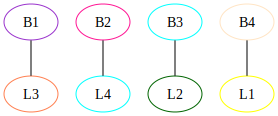

Matching is stable!


In [6]:
# Here is a test case for the classic stable matching problem
bigs = {
    'B1': {},
    'B2': {},
    'B3': {},
    'B4': {}
}

littles = {
    'L1': {},
    'L2': {},
    'L3': {},
    'L4': {}
}

# Preferences designed to test stability constraints
big_prefs = {
    'B1': ['L1', 'L2', 'L3', 'L4'],
    'B2': ['L2', 'L1', 'L4', 'L3'],
    'B3': ['L3', 'L1', 'L2', 'L4'],
    'B4': ['L1', 'L3', 'L2', 'L4']
}

little_prefs = {
    'L1': ['B4', 'B1', 'B2', 'B3'],
    'L2': ['B3', 'B2', 'B1', 'B4'],
    'L3': ['B1', 'B3', 'B4', 'B2'],
    'L4': ['B2', 'B4', 'B1', 'B3']
}

# Create matcher and solve
matcher = BigLittleMatcher(bigs, littles, big_prefs, little_prefs)
matcher.build_model()
matches, score = matcher.solve()
matcher.pretty_print()

# Verify stability
def check_stability(matches):
    for b in bigs:
        for l in littles:
            if (b, l) not in matches:
                # Find current partners
                b_partner = next(l2 for (b2, l2) in matches if b2 == b)
                l_partner = next(b2 for (b2, l2) in matches if l2 == l)
                
                # Check if they prefer each other to current partners
                b_prefers = big_prefs[b].index(l) < big_prefs[b].index(b_partner)
                l_prefers = little_prefs[l].index(b) < little_prefs[l].index(l_partner)
                
                if b_prefers and l_prefers:
                    return False, (b, l)
    return True, None

is_stable, blocking_pair = check_stability(matches)
if is_stable:
    print("Matching is stable!")
else:
    print(f"Matching is NOT stable! Found blocking pair: {blocking_pair}")

### 3. Stable Matching with Ties (SMT) ###

Now we extend the problem to allow for ties in the preference lists

For Ties, we are using a dictionary of Person -> Rank to represent the ties.

We can then build the model as follows:

In [7]:
def build_model_smt(self):
    """
    Build a Stable Marriage model with Ties (SMT).
    
    For preferences, we use:
    - big_prefs[b][l] = rank of little l for big b (lower is better)
    - little_prefs[l][b] = rank of big b for little l (lower is better)
    - This allows for ties (multiple people with same rank)
    
    This function:
    1. Creates binary variables for all possible matches
    2. Adds constraints to ensure each participant is matched exactly once
    3. Adds stability constraints that account for ties:
        - For each potential pair (b,l) that's not matched, either:
            a) b must be matched with someone they rank equally or better than l, or
            b) l must be matched with someone they rank equally or better than b
    """
    for b in self.bigs:
        for l in self.littles:
            self.x[(b, l)] = self.model.NewBoolVar(f"x_{b}_{l}")
    
    for b in self.bigs:
        self.model.Add(sum(self.x[(b, l)] for l in self.littles) == 1)
    for l in self.littles:
        self.model.Add(sum(self.x[(b, l)] for b in self.bigs) == 1)
    
    for b in self.bigs:
        for l in self.littles:
            b_rank_of_l = self.big_prefs[b][l]
            l_rank_of_b = self.little_prefs[l][b]
            
            not_matched = self.model.NewBoolVar(f"not_matched_{b}_{l}")
            self.model.Add(self.x[(b, l)] == 0).OnlyEnforceIf(not_matched)
            self.model.Add(self.x[(b, l)] == 1).OnlyEnforceIf(not_matched.Not())
            
            b_with_better_or_equal = self.model.NewBoolVar(f"b{b}_with_geq_{l}")
            preferred_littles = [
                l_prime for l_prime in self.littles 
                if self.big_prefs[b][l_prime] <= b_rank_of_l
            ]
            self.model.Add(sum(self.x[(b, l_prime)] for l_prime in preferred_littles) >= 1).OnlyEnforceIf(b_with_better_or_equal)
            self.model.Add(sum(self.x[(b, l_prime)] for l_prime in preferred_littles) == 0).OnlyEnforceIf(b_with_better_or_equal.Not())
            
            l_with_better_or_equal = self.model.NewBoolVar(f"l{l}_with_geq_{b}")
            preferred_bigs = [
                b_prime for b_prime in self.bigs 
                if self.little_prefs[l][b_prime] <= l_rank_of_b
            ]
            self.model.Add(sum(self.x[(b_prime, l)] for b_prime in preferred_bigs) >= 1).OnlyEnforceIf(l_with_better_or_equal)
            self.model.Add(sum(self.x[(b_prime, l)] for b_prime in preferred_bigs) == 0).OnlyEnforceIf(l_with_better_or_equal.Not())
            
            self.model.AddBoolOr([not_matched.Not(), b_with_better_or_equal, l_with_better_or_equal])
    
    self.model.Maximize(0)

BigLittleMatcher.build_model_smt = build_model_smt

### 4. Stable Matching with Ties and Incomplete Lists (SMTI) ###

Now we extend the problem to allow for not only ties, but also incomplete lists. 

For Incomplete Lists, the solver will just assign a max rank to the missing preferences.
- In real life, this makes sense, since if someone doesn't rank someone, it is probably because they would rather match with the people they listed. Hard luck lol!

We can then build the model as follows:

In [8]:
def build_model_smti(self):
    """
    Build a Stable Marriage model with Ties and Incomplete lists (SMTI).
    
    For preferences, instead of lists, we use:
    - big_prefs[b][l] = rank of little l for big b (lower is better)
    - little_prefs[l][b] = rank of big b for little l (lower is better)
    - Missing entries indicate unranked participants
    
    This function:
    1. Creates binary variables for all possible matches
    2. Adds constraints to ensure each participant is matched at most once
    3. Only considers stability for pairs where both participants rank each other
    4. Adds stability constraints with ties:
        - For each potential pair (b,l) that's not matched, either:
            a) b must be matched with someone they rank equally or better than l, or
            b) l must be matched with someone they rank equally or better than b
    """
    for b in self.bigs:
        for l in self.littles:
            self.x[(b, l)] = self.model.NewBoolVar(f"x_{b}_{l}")
    
    for b in self.bigs:
        self.model.Add(sum(self.x[(b, l)] for l in self.littles) <= 1)
    for l in self.littles:
        self.model.Add(sum(self.x[(b, l)] for b in self.bigs) <= 1)
    
    for b in self.bigs:
        for l in self.littles:
            b_rank_of_l = self.big_prefs.get(b, {}).get(l, self.max_rank_b)
            l_rank_of_b = self.little_prefs.get(l, {}).get(b, self.max_rank_l)
            
            if b_rank_of_l == self.max_rank_b or l_rank_of_b == self.max_rank_l:
                continue
                
            not_matched = self.model.NewBoolVar(f"not_matched_{b}_{l}")
            self.model.Add(self.x[(b, l)] == 0).OnlyEnforceIf(not_matched)
            self.model.Add(self.x[(b, l)] == 1).OnlyEnforceIf(not_matched.Not())
            
            b_with_better_or_equal = self.model.NewBoolVar(f"b{b}_with_geq_{l}")
            preferred_littles = [
                l_prime for l_prime in self.littles 
                if self.big_prefs.get(b, {}).get(l_prime, self.max_rank_b) <= b_rank_of_l
            ]
            self.model.Add(sum(self.x[(b, l_prime)] for l_prime in preferred_littles) >= 1).OnlyEnforceIf(b_with_better_or_equal)
            self.model.Add(sum(self.x[(b, l_prime)] for l_prime in preferred_littles) == 0).OnlyEnforceIf(b_with_better_or_equal.Not())
            
            l_with_better_or_equal = self.model.NewBoolVar(f"l{l}_with_geq_{b}")
            preferred_bigs = [
                b_prime for b_prime in self.bigs 
                if self.little_prefs.get(l, {}).get(b_prime, self.max_rank_l) <= l_rank_of_b
            ]
            self.model.Add(sum(self.x[(b_prime, l)] for b_prime in preferred_bigs) >= 1).OnlyEnforceIf(l_with_better_or_equal)
            self.model.Add(sum(self.x[(b_prime, l)] for b_prime in preferred_bigs) == 0).OnlyEnforceIf(l_with_better_or_equal.Not())
            
            self.model.AddBoolOr([not_matched.Not(), b_with_better_or_equal, l_with_better_or_equal])
    
    self.model.Maximize(0)

BigLittleMatcher.build_model_smti = build_model_smti

### 4. Stable Matching with Incomplete Lists as Optional Matching ###

Similar to the problem above, but this time, we prefer to leave people unmatched rather than matching them with people they didn't rank. This is useful when it's better to have no match than a poor match.

In [ ]:
def build_model_smi_two(self):
    """
    Build a Stable Marriage model with Ties and Incomplete lists (SMTI).
    
    For preferences, instead of lists, we use:
    - big_prefs[b][l] = rank of little l for big b (lower is better)
    - little_prefs[l][b] = rank of big b for little l (lower is better)
    - Missing entries indicate unranked participants
    - We would rather leave people unmatched than match them to someone they did not rank.
    
    This function:
    1. Creates binary variables for all possible matches
    2. Adds constraints to ensure each participant is matched at most once
    3. Only considers stability for pairs where both participants rank each other
    4. Adds stability constraints with ties:
        - For each potential pair (b,l) that's not matched, either:
            a) b must be matched with someone they rank equally or better than l, or
            b) l must be matched with someone they rank equally or better than b
    """
    for b in self.bigs:
        for l in self.littles:
            self.x[(b, l)] = self.model.NewBoolVar(f"x_{b}_{l}")
    
    # we check make it <= 1, so now not everyone has to be matched.
    for b in self.bigs:
        self.model.Add(sum(self.x[(b, l)] for l in self.littles) <= 1)
    for l in self.littles:
        self.model.Add(sum(self.x[(b, l)] for b in self.bigs) <= 1)
    
    for b in self.bigs:
        for l in self.littles:
            b_rank_of_l = self.big_prefs.get(b, {}).get(l, self.max_rank_b)
            l_rank_of_b = self.little_prefs.get(l, {}).get(b, self.max_rank_l)
            
            if b_rank_of_l == self.max_rank_b or l_rank_of_b == self.max_rank_l:
                continue
                
            not_matched = self.model.NewBoolVar(f"not_matched_{b}_{l}")
            self.model.Add(self.x[(b, l)] == 0).OnlyEnforceIf(not_matched)
            self.model.Add(self.x[(b, l)] == 1).OnlyEnforceIf(not_matched.Not())
            
            b_with_better_or_equal = self.model.NewBoolVar(f"b{b}_with_geq_{l}")
            preferred_littles = [
                l_prime for l_prime in self.littles 
                if self.big_prefs.get(b, {}).get(l_prime, self.max_rank_b) <= b_rank_of_l
            ]
            self.model.Add(sum(self.x[(b, l_prime)] for l_prime in preferred_littles) >= 1).OnlyEnforceIf(b_with_better_or_equal)
            self.model.Add(sum(self.x[(b, l_prime)] for l_prime in preferred_littles) == 0).OnlyEnforceIf(b_with_better_or_equal.Not())
            
            l_with_better_or_equal = self.model.NewBoolVar(f"l{l}_with_geq_{b}")
            preferred_bigs = [
                b_prime for b_prime in self.bigs 
                if self.little_prefs.get(l, {}).get(b_prime, self.max_rank_l) <= l_rank_of_b
            ]
            self.model.Add(sum(self.x[(b_prime, l)] for b_prime in preferred_bigs) >= 1).OnlyEnforceIf(l_with_better_or_equal)
            self.model.Add(sum(self.x[(b_prime, l)] for b_prime in preferred_bigs) == 0).OnlyEnforceIf(l_with_better_or_equal.Not())
            
            self.model.AddBoolOr([not_matched.Not(), b_with_better_or_equal, l_with_better_or_equal])
    
    # we want to minimize the sum of the ranks.
    # Create a dictionary to store the ranks of matched pairs
    temp_scores = {}
    for b in self.bigs:
        for l in self.littles:
            # Only consider pairs that are ranked by both participants
            b_rank_of_l = self.big_prefs.get(b, {}).get(l, self.max_rank_b * 1000)
            l_rank_of_b = self.little_prefs.get(l, {}).get(b, self.max_rank_l * 1000)
            
            if b_rank_of_l >= self.max_rank_b * 1000 or l_rank_of_b >= self.max_rank_l * 1000:
                # Heavily penalize matching unranked participants
                temp_scores[(b, l)] = -(b_rank_of_l + l_rank_of_b)
            else:
                # For ranked pairs, we want to maximize the negative sum of ranks
                # (which is equivalent to minimizing the sum of ranks)
                temp_scores[(b, l)] = -(b_rank_of_l + l_rank_of_b)
    
    # Maximize the negative sum of ranks (equivalent to minimizing the sum of ranks)
    self.model.Maximize(sum(temp_scores[(b, l)] * self.x[(b, l)] for (b, l) in self.x))

### 5. Utilitarian Matching ###

However, note that in real life, perhaps we do not want a stable matching, but rather a matching that optimizes the overall preference score.

Now we extend the problem to allow for a preference weight, which allows for the solver to prefer certain matches over others.

One thing to note is that while this matching is meant to optimize the preference score, it does not guarantee a stable matching, so there may be people unhappy with the matching, however the overall preference score is optimized.

We can then build the model as follows:

In [10]:
def build_model_optimize(self, preference_weight: float = 0.5, enforce_exactly_one: bool = False):
    #x[(b, l)] is 1 if big b is matched with little l
    for b in self.bigs:
        for l in self.littles:
            self.x[(b, l)] = self.model.NewBoolVar(f"x_{b}_{l}")

    
    for l in self.littles:
        vars_l = [self.x[(b, l)] for b in self.bigs]
        # each little must be matched to exactly one big
        if enforce_exactly_one:
            self.model.Add(sum(vars_l) == 1)
        # there are twins
        else:
            self.model.Add(sum(vars_l) >= 1)
            self.model.Add(sum(vars_l) <= self.littles[l].get('max', 1))

    for b in self.bigs:
        vars_b = [self.x[(b, l)] for l in self.littles]
        # if exact matching
        if enforce_exactly_one:
            self.model.Add(sum(vars_b) == 1)
        # each big must be matched to at least one little
        # and no more than their max
        else:
            self.model.Add(sum(vars_b) >= 1)
            self.model.Add(sum(vars_b) <= self.bigs[b].get('max', 1))

    for b in self.bigs:
        for l in self.littles:
            # lower rank means higher preference
            # assigns max_rank to unranked people
            rank_b = self.big_prefs.get(b, []).index(l) if l in self.big_prefs.get(b, []) else self.max_rank_b
            rank_l = self.little_prefs.get(l, []).index(b) if b in self.little_prefs.get(l, []) else self.max_rank_l

            score = (
                preference_weight * (self.max_rank_b - rank_b)
                + (1 - preference_weight) * (self.max_rank_l - rank_l)
            )
            self.scores[(b, l)] = score

    self.model.Maximize(sum(self.scores[(b, l)] * self.x[(b, l)] for (b, l) in self.x))

BigLittleMatcher.build_model_optimize = build_model_optimize

Basic test case below.

CpSolverResponse summary:
status: OPTIMAL
objective: 8
best_bound: 8
integers: 6
booleans: 9
conflicts: 0
branches: 22
propagations: 41
integer_propagations: 36
restarts: 19
lp_iterations: 0
walltime: 0.003275
usertime: 0.003275
deterministic_time: 2.0528e-05
gap_integral: 2.06909e-06
solution_fingerprint: 0x27b8fff9edcd2da2

Total preference score: 8


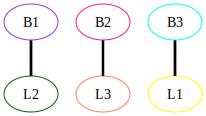

In [11]:
bigs = {
    'B1': {'max': 2},
    'B2': {'max': 1},
    'B3': {'max': 1},
}

littles = {
    'L1': {'max': 1},
    'L2': {'max': 1},
    'L3': {'max': 2},
}

big_prefs = {
    'B1': ['L2', 'L1', 'L3'],
    'B2': ['L3', 'L1', 'L2'],
    'B3': ['L1', 'L2', 'L3']
}

little_prefs = {
    'L1': ['B1', 'B3', 'B2'],
    'L2': ['B2', 'B1', 'B3'],
    'L3': ['B3', 'B1', 'B2']
}

matcher = BigLittleMatcher(bigs, littles, big_prefs, little_prefs)
matcher.build_model_optimize(preference_weight=0.75, enforce_exactly_one=True)
soln, obj_value = matcher.solve()
matcher.pretty_print()

What happens if bigs and littles have completely opposite preferences, but `preference_weight` = 0.5?

CpSolverResponse summary:
status: OPTIMAL
objective: 7.5
best_bound: 7.5
integers: 7
booleans: 9
conflicts: 0
branches: 22
propagations: 41
integer_propagations: 43
restarts: 19
lp_iterations: 0
walltime: 0.003061
usertime: 0.003061
deterministic_time: 2.0528e-05
gap_integral: 1.9824e-06
solution_fingerprint: 0x27b8fff9edcd2da2

Total preference score: 8


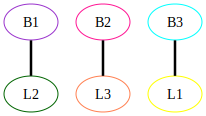

Matches:
  B1 ↔ L2
  B2 ↔ L3
  B3 ↔ L1


In [12]:
bigs = {
    'B1': {'max': 1},
    'B2': {'max': 1},
    'B3': {'max': 1},
}

littles = {
    'L1': {'max': 1},
    'L2': {'max': 1},
    'L3': {'max': 1},
}

big_prefs = {
    'B1': ['L1', 'L2', 'L3'],
    'B2': ['L2', 'L3', 'L1'],
    'B3': ['L3', 'L1', 'L2'],
}

little_prefs = {
    'L1': ['B3', 'B2', 'B1'],  # reverse of B1
    'L2': ['B1', 'B3', 'B2'],  # reverse of B2
    'L3': ['B2', 'B1', 'B3'],  # reverse of B3
}

matcher = BigLittleMatcher(bigs, littles, big_prefs, little_prefs)
matcher.build_model_optimize(preference_weight=0.5, enforce_exactly_one=True)
matches, obj_value = matcher.solve()
matcher.pretty_print()
print("Matches:")
for b, l in matches:
    print(f"  {b} ↔ {l}")

Complex test case:

CpSolverResponse summary:
status: OPTIMAL
objective: 47
best_bound: 47
integers: 36
booleans: 36
conflicts: 0
branches: 80
propagations: 208
integer_propagations: 284
restarts: 73
lp_iterations: 0
walltime: 0.059691
usertime: 0.059691
deterministic_time: 9.8681e-05
gap_integral: 3.22687e-05
solution_fingerprint: 0x6dfd2262cd2df959

Total preference score: 47


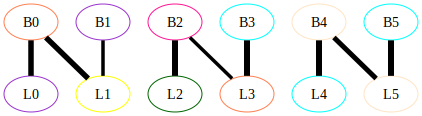

Matches:
  B0 ↔ L0
  B0 ↔ L1
  B1 ↔ L1
  B2 ↔ L2
  B2 ↔ L3
  B3 ↔ L3
  B4 ↔ L4
  B4 ↔ L5
  B5 ↔ L5


In [13]:
bigs = {
    f'B{i}': {'max': 2 if i % 2 == 0 else 1} for i in range(6)
}

littles = {
    f'L{i}': {'max': 1 if i % 2 == 0 else 2} for i in range(6)
}

big_prefs = {
    'B0': ['L0', 'L1', 'L2', 'L3', 'L4', 'L5'],
    'B1': ['L1', 'L0', 'L2', 'L5', 'L4', 'L3'],
    'B2': ['L2', 'L3', 'L0', 'L1', 'L5', 'L4'],
    'B3': ['L3', 'L2', 'L1', 'L0', 'L5', 'L4'],
    'B4': ['L4', 'L5', 'L0', 'L1', 'L2', 'L3'],
    'B5': ['L5', 'L4', 'L3', 'L2', 'L1', 'L0'],
}

little_prefs = {
    'L0': ['B1', 'B0', 'B3', 'B2', 'B5', 'B4'],
    'L1': ['B0', 'B2', 'B4', 'B5', 'B3', 'B1'],
    'L2': ['B2', 'B3', 'B1', 'B0', 'B4', 'B5'],
    'L3': ['B3', 'B4', 'B5', 'B0', 'B2', 'B1'],
    'L4': ['B4', 'B5', 'B0', 'B1', 'B3', 'B2'],
    'L5': ['B5', 'B4', 'B2', 'B3', 'B0', 'B1'],
}

matcher = BigLittleMatcher(bigs, littles, big_prefs, little_prefs)
matcher.build_model_optimize(enforce_exactly_one=False)
matches, obj_value = matcher.solve()
matcher.pretty_print()
print("Matches:")
for b, l in matches:
    print(f"  {b} ↔ {l}")

What is interesting is that while it is not guaranteed to be stable, in all of our testing, the optimal solver solution was stable.